In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.special import factorial
import os
import sys
sys.path.append('/home/astridaurora/HESE-7-year-data-release/HESE-7-year-data-release')
from Astrid.effective_area import bin_edges_to_centers, bin_centers_to_edges, apply_energy_smearing
import nuSIprop

import emcee
import corner

1. Divide each flavor in interaction types

2. Multiply each flavor-interaction catergory of flux by the corresponding effective area.

3. Convert to morphologies.

4. Apply resolution per morphology.

5. 
a. Sum all events + bin + compare to HESE12.
b. Bin + Compare to HESE12 for cascades vs tracks. 

Defining fractions based on HESE 7.5, table IV on page 8.

In [2]:


morph_frac = {
    "cascade": 0.727,
    "track": 0.234,
    "dcascade": 0.039
}

interaction_given_morph = {
    "cascade": {"CC": 0.843, "NC": 0.148, "GR": 0.009},
    "track": {"CC": 0.902, "NC": 0.026, "GR": 0.003},
    "dcascade": {"CC": 0.920, "NC": 0.069, "GR": 0.012}
}

cc_flavor_given_morph = {
    "cascade": {"nu_e": 0.519, "nu_mu": 0.087, "nu_tau": 0.236},
    "track": {"nu_e": 0.088, "nu_mu": 0.716, "nu_tau": 0.098},
    "dcascade": {"nu_e": 0.182, "nu_mu": 0.109, "nu_tau": 0.629}
}

flavor_given_morph = {
    "cascade": {"nu_e": 0.567, "nu_mu": 0.157, "nu_tau": 0.276},
    "track": {"nu_e": 0.098, "nu_mu": 0.728, "nu_tau": 0.105},
    "dcascade": {"nu_e": 0.211, "nu_mu": 0.142, "nu_tau": 0.647}
}



Get the dataframes for the HESE12 data and scaled background events. No need to replace zeros in the dataframe as log(factorial(0)) = 0.

In [22]:
energy_bins = np.logspace(4, 7, 3*20+1)
energy_centers = bin_edges_to_centers(energy_bins)
energy_bins_low_resolution = np.logspace(4, 7, 20+1)
energy_centers_low_resolution = bin_edges_to_centers(energy_bins_low_resolution)

livetime12 = 12*365*24*3600

hese12_events_df = pd.read_csv('4_to_7_HESE12/20bins/hese12_20bins_df.csv', index_col=0)
print(hese12_events_df)

cascade_data_df = pd.read_csv('4_to_7_HESE12/20bins/cascade_events_12.csv', index_col=0)
track_data_df = pd.read_csv('4_to_7_HESE12/20bins/track_events_12.csv', index_col=0)
dcascade_data_df = pd.read_csv('4_to_7_HESE12/20bins/dcascade_events_12.csv', index_col=0)


background_df = pd.read_csv('4_to_7_HESE12/20bins/background_20bins_df.csv', index_col=0)
background_df.rename(columns={'background': 'events'}, inplace=True)

cascade_background_df = pd.read_csv('4_to_7_HESE12/20bins/background_cascade_events_12.csv', index_col=0)
track_background_df = pd.read_csv('4_to_7_HESE12/20bins/background_track_events_12.csv', index_col=0)
dcascade_background_df = pd.read_csv('4_to_7_HESE12/20bins/background_dcascade_events_12.csv', index_col=0)



              events
1.188502e+04       0
1.678804e+04       1
2.371374e+04      18
3.349654e+04      25
4.731513e+04      25
6.683439e+04      23
9.440609e+04      27
1.333521e+05      23
1.883649e+05       8
2.660725e+05       4
3.758374e+05       4
5.308844e+05       1
7.498942e+05       1
1.059254e+06       2
1.496236e+06       0
2.113489e+06       1
2.985383e+06       0
4.216965e+06       1
5.956621e+06       0
8.413951e+06       0


In [23]:
print(cascade_data_df['events'].sum())

109


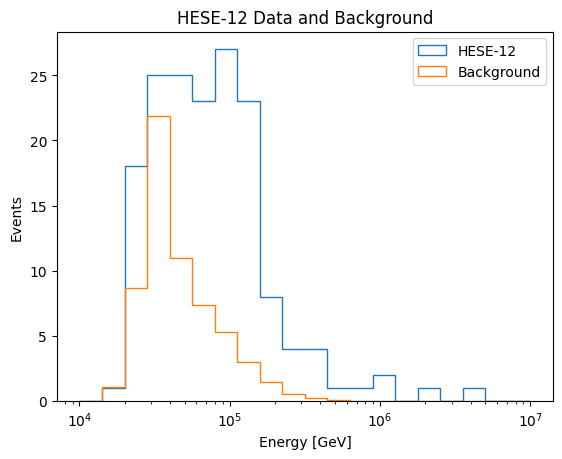

In [19]:
plt.hist(hese12_events_df.index, bins=energy_bins_low_resolution, weights=hese12_events_df['events'], histtype='step', label='HESE-12')
plt.hist(background_df.index, bins=energy_bins_low_resolution, weights=background_df['events'], histtype='step', label='Background')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Events')
plt.title('HESE-12 Data and Background')
plt.legend()
plt.show()

In [6]:
print(background_df['events'].sum())
print(cascade_background_df['events'].sum(), track_background_df['events'].sum(), dcascade_background_df['events'].sum())
print(cascade_background_df['events'].sum() + track_background_df['events'].sum() + dcascade_background_df['events'].sum())

60.60609523231524
20.82110159900834 39.137880481360575 0.6471131519465904
60.6060952323155


In [8]:
print(hese12_events_df['events'].sum())
print(cascade_data_df['events'].sum(), track_data_df['events'].sum(), dcascade_data_df['events'].sum())
print(cascade_data_df['events'].sum() + track_data_df['events'].sum() + dcascade_data_df['events'].sum())

164
109 55 0
164


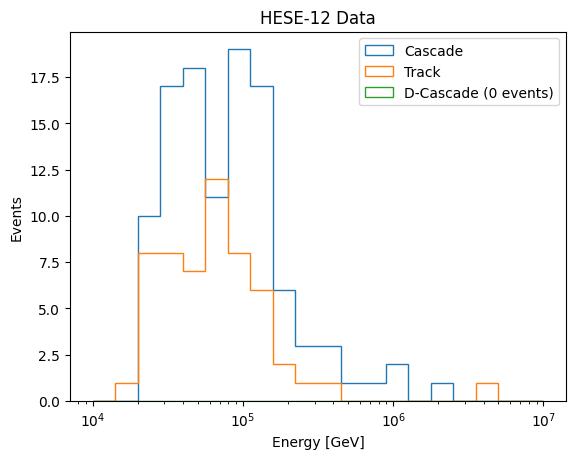

In [10]:
plt.hist(cascade_data_df.index, bins=energy_bins_low_resolution, weights=cascade_data_df['events'], histtype='step', label='Cascade')
plt.hist(track_data_df.index, bins=energy_bins_low_resolution, weights=track_data_df['events'], histtype='step', label='Track')
plt.hist(dcascade_data_df.index, bins=energy_bins_low_resolution, weights=dcascade_data_df['events'], histtype='step', label='D-Cascade (0 events)')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Events')
plt.title('HESE-12 Data')
plt.legend()
plt.show()

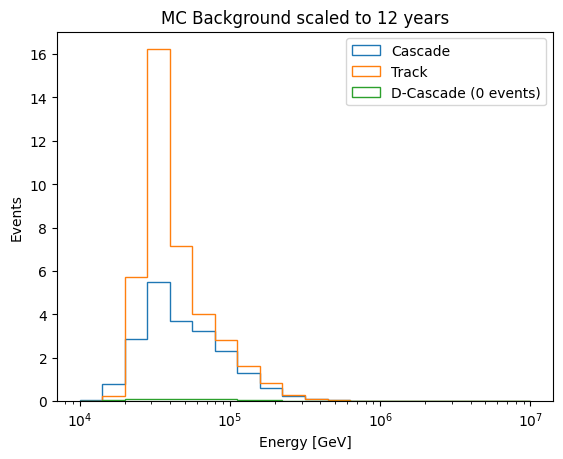

In [21]:
plt.hist(cascade_background_df.index, bins=energy_bins_low_resolution, weights=cascade_background_df['events'], histtype='step', label='Cascade')
plt.hist(track_background_df.index, bins=energy_bins_low_resolution, weights=track_background_df['events'], histtype='step', label='Track')
plt.hist(dcascade_background_df.index, bins=energy_bins_low_resolution, weights=dcascade_background_df['events'], histtype='step', label='D-Cascade (0 events)')
plt.xscale('log')
plt.xlabel('Energy [GeV]')
plt.ylabel('Events')
plt.title('MC Background scaled to 12 years')
plt.legend()
plt.show()

Get the effective areas for each (flavor, interaction). 

Note that the effective area for nu_tau GR is non-zero!

In [12]:
effective_area_df = pd.read_csv('4_to_7_HESE12/60bins/effective_area_4_to_7_interaction_types.csv', index_col=0)
print(effective_area_df)
print(len(effective_area_df))

effective_area_original_df = pd.read_csv('4_to_7_HESE12/60bins/effective_area_4_to_7.csv', index_col=0)
print(effective_area_original_df)


                nu_e_CC    nu_e_NC     nu_e_GR   nu_mu_CC   nu_mu_NC  \
1.059254e+04   0.000000   0.000000    0.000000   0.000000   0.000000   
1.188502e+04   0.000000   0.000000    0.000000   0.000000   0.000000   
1.333521e+04   0.000650   0.000000    0.000000   0.000000   0.000000   
1.496236e+04   0.001655   0.000000    0.000000   0.000000   0.000000   
1.678804e+04   0.005214   0.000000    0.000000   0.000231   0.000000   
1.883649e+04   0.022066   0.000000    0.000000   0.001210   0.000000   
2.113489e+04   0.042446   0.000555    0.000135   0.003199   0.000914   
2.371374e+04   0.091794   0.001838    0.000000   0.005062   0.001902   
2.660725e+04   0.155892   0.002288    0.000000   0.010339   0.003568   
2.985383e+04   0.251606   0.007032    0.000432   0.024836   0.005873   
3.349654e+04   0.373896   0.014457    0.001868   0.038500   0.015582   
3.758374e+04   0.533696   0.019558    0.000450   0.063319   0.019055   
4.216965e+04   0.743293   0.030678    0.000707   0.101553   0.02

Initialize the flux "evolver" object (outside the loops).

In [13]:
M_phi = 5.5
g_phi = 0.035
si = 2.85
norm = 4.0*1e-18

evolver = nuSIprop.pyprop(mphi = M_phi*1e6, # Mediator mass [eV]
			  g = g_phi, # Coupling
			  mntot = 0.1, # Sum of neutrino masses [eV]
			  si = si, # Spectral index
			  norm = norm, # Normalization of the free-streaming flux at 100 TeV [Default = 1]
			  majorana = True, # Majorana neutrinos? [Default = True]
			  non_resonant = True, # Include non s-channel contributions? Relevant for couplings g>~0.1 [Default = True]
			  normal_ordering = True, # Normal neutrino mass ordering? [Default = True]
			  N_bins_E = 300, # Number of energy bins, uniformly distributed in log space [Default = 300]
			  lEmin = 13, # log_10 (E_min/eV) [Default = 13]
			  lEmax = 16, # log_10 (E_max/eV) [Default = 17]
			  zmax = 5, # Largest redshift at which sources are included [Default = 5]
			  flav = 2, # Flavor of interacting neutrinos [0=e, 1=mu, 2=tau. Default = 2]
			  phiphi = False # Consider double-scalar production? If set to true, the files xsec/alpha_phiphi.bin and xsec/alphatilde_phiphi.bin must exist [Default = False]
                          )

evolver.evolve()

flx = evolver.get_flux_fla()
flx_df = pd.DataFrame(flx.T, index=evolver.get_energies(), columns=['nu_e', 'nu_mu', 'nu_tau'])
#flx_df['total'] = flx_df['nu_e'] + flx_df['nu_mu'] + flx_df['nu_tau']
energies = evolver.get_energies()
bin_edges_high_resolution = bin_centers_to_edges(energies)
delta_E = np.diff(bin_edges_high_resolution)    # Delta E in eV
#flx_df.index = flx_df.index / 1e9    # Convert to [GeV] to align with eff_df. 

Functions to manage the conversions between flavors, interactions and morphologies.

In [14]:
def events_by_flavor_and_interaction(flx, eff, livetime, norm, delta_E):
    # Interpolate `flx` to the same energy bins as `eff`
    flx_interpolated = pd.DataFrame(
    {col: interp1d(flx.index, flx[col], bounds_error=False, fill_value="extrapolate")(eff.index)
     for col in flx.columns},
    index=eff.index)
    
    """for key in eff.keys():
        if eff[key].any() < 0:
            print('Negative effective area found')"""
            
    #print(flx_interpolated.shape, eff.shape, delta_E.shape)    
    
    events_df = flx_interpolated * eff * livetime * norm 
    #print(events_df)
    
    for key in events_df.keys():
        
        if events_df[key].any() < 0:
            print('Negative events found')
            negative_mask = events_df[key] < 0
            events_df[key][negative_mask] = 0
        
        events_df[key] = events_df[key] * delta_E

    return events_df


def compute_interaction_fractions_df(flx_df, morph_frac, interaction_given_morph, cc_flavor_given_morph, flavor_given_morph):
    """
    Compute interaction-type fractions (CC, NC, GR) for each flavor across energy bins in a flux DataFrame.

    Parameters:
        flx_df (pd.DataFrame): DataFrame of shape (E, 3), with columns ['nu_e', 'nu_mu', 'nu_tau']
        morph_frac (dict): Fraction of events per morphology
        interaction_given_morph (dict): Fraction of CC, NC, GR within each morphology
        cc_flavor_given_morph (dict): Flavor composition of CC events within each morphology
        flavor_given_morph (dict): Flavor composition of all events in each morphology

    Returns:
        pd.DataFrame: Shape (E, 9), with columns like 'nu_e_CC', 'nu_e_NC', 'nu_e_GR', ..., 'nu_tau_GR'
    """
    flavors = ['nu_e', 'nu_mu', 'nu_tau']
    interactions = ['CC', 'NC', 'GR']
    morphologies = morph_frac.keys()

    # Precompute weights N[flav][intxn] = sum over morphologies of (morph_frac * P(intxn|morph) * P(flav|intxn,morph))
    weights = {flav: {intxn: 0.0 for intxn in interactions} for flav in flavors}

    for morph in morphologies:
        f_morph = morph_frac[morph]
        for intxn in interactions:
            p_intxn = interaction_given_morph[morph][intxn]
            for flav in flavors:
                if intxn == 'CC':
                    p_flav = cc_flavor_given_morph[morph][flav]
                else:
                    p_flav = flavor_given_morph[morph][flav]
                weights[flav][intxn] += f_morph * p_intxn * p_flav

    # Convert weights to fractions per flavor
    frac = {flav: {} for flav in flavors}
    for flav in flavors:
        total = sum(weights[flav][intxn] for intxn in interactions)
        for intxn in interactions:
            frac[flav][intxn] = weights[flav][intxn] / total if total > 0 else 0.0

    # Apply fractions to flux dataframe
    result_dict = {}
    for flav in flavors:
        for intxn in interactions:
            col_name = f"{flav}_{intxn}"
            result_dict[col_name] = flx_df[flav] * frac[flav][intxn]

    return pd.DataFrame(result_dict, index=flx_df.index)



def convert_flux_to_morphologies(intxn_df, morph_frac, interaction_given_morph, cc_flavor_given_morph, flavor_given_morph):
    """
    Converts a DataFrame with 9 columns (flavor-interaction pairs) into morphology fluxes (cascade, track, dcascade).
    
    Parameters:
        intxn_df (pd.DataFrame): Flux DataFrame with columns like 'nu_e_CC', 'nu_mu_NC', ..., shape (E, 9)
        morph_frac (dict): Fraction of total events per morphology
        interaction_given_morph (dict): Fraction of each interaction per morphology
        cc_flavor_given_morph (dict): Flavor composition of CC events within each morphology
        flavor_given_morph (dict): Flavor composition of total events within each morphology

    Returns:
        pd.DataFrame: Flux per morphology, columns = ['cascade', 'track', 'dcascade'], shape (E, 3)
    """
    flavors = ['nu_e', 'nu_mu', 'nu_tau']
    interactions = ['CC', 'NC', 'GR']
    morphologies = list(morph_frac.keys())

    # Build P(morph | flavor, interaction)
    P_morph_given_flav_intxn = {}
    for flav in flavors:
        for intxn in interactions:
            weights = {}
            for morph in morphologies:
                p_morph = morph_frac[morph]
                p_intxn_given_morph = interaction_given_morph[morph][intxn]
                if intxn == 'CC':
                    p_flav_given_morph_intxn = cc_flavor_given_morph[morph][flav]
                else:
                    p_flav_given_morph_intxn = flavor_given_morph[morph][flav]

                weights[morph] = p_morph * p_intxn_given_morph * p_flav_given_morph_intxn

            # Normalize
            total = sum(weights.values())
            if total > 0:
                normed = {m: weights[m]/total for m in morphologies}
            else:
                normed = {m: 0.0 for m in morphologies}
            P_morph_given_flav_intxn[(flav, intxn)] = normed

    # Initialize output
    out_df = pd.DataFrame(0.0, index=intxn_df.index, columns=morphologies)

    for flav in flavors:
        for intxn in interactions:
            col = f"{flav}_{intxn}"
            if col not in intxn_df.columns:
                continue
            for morph in morphologies:
                weight = P_morph_given_flav_intxn[(flav, intxn)][morph]
                out_df[morph] += intxn_df[col] * weight

    return out_df



In [15]:
def log_Jeffreys_prior(theta):
    #Mphi, g, mntot, si, norm = theta
    #Mphi, g, si, norm = theta
    Mphi, g, si = theta
    
    # Use log-uniform priors for better exploration
    if not (1e-4 < g < 1):
        return -np.inf
    if not (0.1 < Mphi < 1000):
        return -np.inf
    #if not (0.06 < mntot < 0.12):
    #    return -np.inf
    if not (2.0 < si < 3.0):
        return -np.inf
    #if not (1e-19 < norm < 1e-17):  # Much wider range
    #    return -np.inf
    
    # Log-uniform prior: log(1/x) = -log(x)
    #return -np.log(g) - np.log(Mphi) - np.log(norm)
    return -np.log(g) - np.log(Mphi)
    

def log_prior_uniform(theta):
    """
    Uniform prior (for comparison)
    """
    #Mphi, g, mntot, si, norm = theta
    #Mphi, g, si, norm = theta
    Mphi, g, si = theta
    
    # Check bounds
    if not (1e-4 < g < 1):
        return -np.inf
    if not (0.1 < Mphi < 1000):
        return -np.inf
    #if not (0.06 < mntot < 0.12):
    #    return -np.inf
    if not (2.0 < si < 3.0):
        return -np.inf
    #if not (1e-19 < norm < 1e-17):
    #    return -np.inf
    
    # Uniform prior (constant)
    return 0.0


def log_likelihood_poisson(data, predicted):
    # From Poisson distribution 
    return np.sum(-predicted + data*np.log(predicted) - np.log(factorial(data)))


def log_likelihood_original(theta):
    Mphi, g, si = theta

    evolver.set_parameters(mphi=Mphi*1e6, g=g, si=si)
    evolver.evolve()
    flux = evolver.get_flux_fla()

    flx_df = pd.DataFrame(flux.T, index=energies, columns=['nu_e', 'nu_mu', 'nu_tau'])
    flx_df.index = flx_df.index / 1e9

    nuSIprop_df = events_by_flavor_and_interaction(flx=effective_area_original_df, eff=flx_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
    nuSIprop_df['total_events'] = nuSIprop_df['nu_e'] + nuSIprop_df['nu_mu'] + nuSIprop_df['nu_tau']
    nuSIprop_smeared = apply_energy_smearing(energies=nuSIprop_df.index.values, events=nuSIprop_df['total_events'].values, resolution=0.1)

    nuSIprop_binned_events, _ = np.histogram(nuSIprop_df.index.values, weights=nuSIprop_smeared, bins=energy_bins_low_resolution)
    print(nuSIprop_binned_events)
    predicted = nuSIprop_binned_events + background_df['events'].values
    print(predicted)

    return log_likelihood_poisson(data=hese12_events_df['events'].values.astype(int), predicted=predicted)


def log_likelihood_a(theta):
    # Alternative a: Sum all events, then bin, then compare to data.
    # Hence, the major difference to the original is applying different resolutions.
    
    Mphi, g, si = theta

    # Update and evolve the flux with the new parameters.
    evolver.set_parameters(mphi=Mphi*1e6, g=g, si=si)
    evolver.evolve()
    flux = evolver.get_flux_fla()
    flx_df = pd.DataFrame(flux.T, index=energies, columns=['nu_e', 'nu_mu', 'nu_tau'])
    
    # Split into interaction types.
    flx_interaction_df = compute_interaction_fractions_df(flx_df, morph_frac, interaction_given_morph, cc_flavor_given_morph, flavor_given_morph)
    #print(flx_interaction_df)
    flx_interaction_df.index = flx_interaction_df.index / 1e9

    # Compute the number of events for each flavor and interaction type.
    interaction_events_df = events_by_flavor_and_interaction(flx=effective_area_df, eff=flx_interaction_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
    
    # Convert to morphologies.
    morph_events_df = convert_flux_to_morphologies(
        intxn_df=interaction_events_df, 
        morph_frac=morph_frac,
        interaction_given_morph=interaction_given_morph,
        cc_flavor_given_morph=cc_flavor_given_morph,
        flavor_given_morph=flavor_given_morph
    )
    cascade_events_smeared = apply_energy_smearing(energies=morph_events_df.index.values, events=morph_events_df['cascade'].values, resolution=0.11)
    track_events_smeared = apply_energy_smearing(energies=morph_events_df.index.values, events=morph_events_df['track'].values, resolution=0.30)
    d_cascade_events_smeared = apply_energy_smearing(energies=morph_events_df.index.values, events=morph_events_df['dcascade'].values, resolution=0.18)

    cascade_binned_events, _ = np.histogram(a=morph_events_df.index.values, weights=cascade_events_smeared, bins=energy_bins_low_resolution)
    track_binned_events, _ = np.histogram(a=morph_events_df.index.values, weights=track_events_smeared, bins=energy_bins_low_resolution)
    d_cascade_binned_events, _ = np.histogram(a=morph_events_df.index.values, weights=d_cascade_events_smeared, bins=energy_bins_low_resolution)

    predicted = cascade_binned_events + track_binned_events + d_cascade_binned_events + background_df['events'].values
    
    return log_likelihood_poisson(data=hese12_events_df['events'].values.astype(int), predicted=predicted)


def log_likelihood_b(theta):
    # Alternative b: Bin, then compare to HESE12 for each morphology respectively.
    
    Mphi, g, si = theta

    # Update and evolve the flux with the new parameters.
    evolver.set_parameters(mphi=Mphi*1e6, g=g, si=si)
    evolver.evolve()
    flux = evolver.get_flux_fla()
    flx_df = pd.DataFrame(flux.T, index=energies, columns=['nu_e', 'nu_mu', 'nu_tau'])
    
    # Split into interaction types.
    flx_interaction_df = compute_interaction_fractions_df(flx_df, morph_frac, interaction_given_morph, cc_flavor_given_morph, flavor_given_morph)
    #print(flx_interaction_df)
    flx_interaction_df.index = flx_interaction_df.index / 1e9

    # Compute the number of events for each flavor and interaction type.
    interaction_events_df = events_by_flavor_and_interaction(flx=effective_area_df, eff=flx_interaction_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
    
    # Convert to morphologies.
    morph_events_df = convert_flux_to_morphologies(
        intxn_df=interaction_events_df, 
        morph_frac=morph_frac,
        interaction_given_morph=interaction_given_morph,
        cc_flavor_given_morph=cc_flavor_given_morph,
        flavor_given_morph=flavor_given_morph
    )
    cascade_events_smeared = apply_energy_smearing(energies=morph_events_df.index.values, events=morph_events_df['cascade'].values, resolution=0.11)
    track_events_smeared = apply_energy_smearing(energies=morph_events_df.index.values, events=morph_events_df['track'].values, resolution=0.30)
    d_cascade_events_smeared = apply_energy_smearing(energies=morph_events_df.index.values, events=morph_events_df['dcascade'].values, resolution=0.18)

    
    #predicted = cascade_binned_events + track_binned_events + d_cascade_binned_events + background_df['events'].values
    #print(predicted)
    
    cascade_binned_events, _ = np.histogram(a=morph_events_df.index.values, weights=cascade_events_smeared, bins=energy_bins_low_resolution)
    track_binned_events, _ = np.histogram(a=morph_events_df.index.values, weights=track_events_smeared, bins=energy_bins_low_resolution)
    d_cascade_binned_events, _ = np.histogram(a=morph_events_df.index.values, weights=d_cascade_events_smeared, bins=energy_bins_low_resolution)

    predicted_cascade = cascade_binned_events + cascade_background_df['events'].values
    predicted_track = track_binned_events + track_background_df['events'].values
    predicted_dcascade = d_cascade_binned_events + dcascade_background_df['events'].values
    
    ll_cascade = log_likelihood_poisson(data=cascade_data_df['events'].values.astype(int), predicted=predicted_cascade)
    ll_track = log_likelihood_poisson(data=track_data_df['events'].values.astype(int), predicted=predicted_track)
    ll_dcascade = log_likelihood_poisson(data=dcascade_data_df['events'].values.astype(int), predicted=predicted_dcascade)
    print(ll_cascade, ll_track, ll_dcascade)
    
    return ll_cascade + ll_track + ll_dcascade


def log_posterior(theta):

    lp = log_prior_uniform(theta)
    #lp = log_Jeffreys_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_a(theta)

    if np.random.random() < 0.03:  # Print 3% of calls
        print(f"Testing: Mphi={theta[0]:.2f}, g={theta[1]:.2e}, si={theta[2]:.2f}")
        print(f"Log Prior: {lp:.2f}, Log Likelihood: {ll:.2f}")
    return lp + ll


Using the 'original' log likelihood with no interaction/morphology treatment gives -58. This is however different from in the file chi2.ipynb!!!!

Using alternative a gives ll = -46.8, for theta=(25, 0.05, 2.5)

Using alternative b gives (ll_casc, ll_track, ll_dcasc) = (-42, -31, -6), for theta=(25, 0.05, 2.5)

In [72]:
log_l = log_likelihood_original(theta=(25, 0.05, 2.5))
print(log_l)

[ 0.01950078  0.37623687  2.08921853  5.43918121 10.05827324 15.18629334
 18.33781638 18.60279354 16.52881292 13.62108174 10.69096706  8.17444926
  6.19656508  4.77563779  3.61294486  2.57804569  1.48479074  0.63097904
  1.31062865  0.42559848]
[ 0.06120359  1.48814522 10.76329067 27.28220405 21.01407491 22.53383051
 23.6032593  21.580177   17.98787595 14.18139195 10.91500689  8.26981844
  6.22950422  4.78771782  3.61645309  2.57930352  1.48521972  0.63112821
  1.31069369  0.42561168]
-58.11878419830791


theta = (5.5, 0.035, 2.85):

Original: -32.27

Alt. a: -34.95

Alt. b: -66.73


In [20]:
log_l = log_likelihood_b(theta=(5.5, 0.035, 2.85))
print(log_l)

-34.201518980597875 -27.956445287419463 -4.574602901263153
-66.73256716928049
